# Flow Forecasting at Verde River, Arizona

## Developed by Camilo Salcedo for HAS-Tools in Fall 2020
### November 23/2020


## 1. Purpose

The Verde River is one of the biggest perennial streams in the state of Arizona. With an average flow of 600 cfs and a length of approximately 170 mi, Verde river is a major tributary for the Salt River in the state. As part of the course _HAS Tools_ in Fall 2020, a forecasting contest is being held along the semester. Therefore, the purpose of this notebook is to present and share all the tasks involved in the forecasting activity, mainly codes and their explanation, that have been developed during the semester.

Two types of forecasts are presented: _Weekly forecasts_, which goes 1 and 2 week ahead of the forecast date, and _Seasonal forecast_, which predicts the streamflow values for each week between 08/22/2020 and 12/12/2020, using data until 08/21/2020.

## 2. Location of Verde River

The Verde River starts flowing from northern Arizona, near to the city of Flagstaff. Downstream, it delivers its flow to Salt River, near Phoenix. 

The Verde River's location is shown in the map below, including the boundaries of its basins as well as the stream gages available for the data collection.

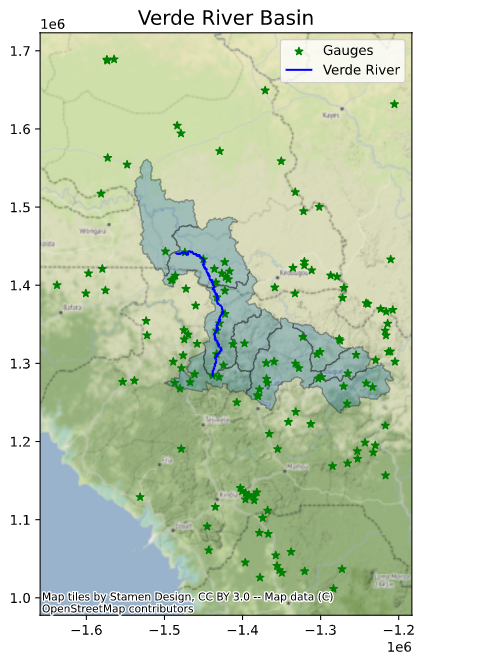

*Note*: The map was pasted as an image due to the size of the shapefiles. The code is presented below, but it will not work. Sorry :( 

In [ ]:
import geopandas as gpd
import fiona
from shapely.geometry import Point
import contextily as ctx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Upload the datasets used in the map

# Dataset 1: Gages in Shapefile
# Download at: https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml#stdorder

file_name = '02_Mapping/Definitive/gages/gagesII_9322_sept30_2011.shp'
file_boundaries = os.path.join('../../../../', file_name)
gages = gpd.read_file(file_boundaries)

# %%
# Dateset 2: Rivers and Streams at US
# Download at: https://hub.arcgis.com/datasets/esri::usa-rivers-and-streams
file_rivers_name = '02_Mapping/Definitive/USA_Rivers/riversshape.shp'
file_rivers = os.path.join('../../../../', file_rivers_name)
rivers = gpd.read_file(file_rivers)

# %%
# Dataset 3: Basin boundaries in the US
# Download at: https://viewer.nationalmap.gov/basic/?basemap=b1&category=nhd&title=NHD%20View
file_boundaries_name = '02_Mapping/Definitive/basin/basin.shp'
file_boundaries = os.path.join('../../../..', file_boundaries_name)
boundaries = gpd.read_file(file_boundaries)
# %%
# Information Preparation
# Extract the gauges from Arizona
gages_AZ = gages[gages['STATE'] == 'AZ']
AZ_rivers = rivers.loc[rivers['Name'] == 'Verde River']

# Validate the reference system
print('Gauges:', gages.crs)
print('Basins:', boundaries.crs)
print('Rivers:', rivers.crs)

# The reference system is different for each dataset. They will be projected.

basins_project = boundaries.to_crs(gages_AZ.crs)
rivers_project = AZ_rivers.to_crs(gages_AZ.crs)

# %%
# Plotting the map

# Zoom  in and just look at AZ
gages.columns
gages.STATE.unique()
gages_AZ = gages[gages['STATE'] == 'AZ']
gages_AZ.shape

# Plotting
fig, ax = plt.subplots(figsize=(5, 10))

ax.set_title('Verde River Basin', fontsize=15)

basins_project.plot(ax=ax, label='Basins',
                    edgecolor='black', alpha=0.3, legend=True)
gages_AZ.plot(ax=ax, label='Gauges', marker='*', color='green')
rivers_project.plot(ax=ax, label='Verde River', color='blue')
ax.legend()
ctx.add_basemap(ax)

plt.show()

## 3. Forecast Description

In this section, the approach used to perform the forecast of the Verde River streamflow is described. First of all, please import all packages listed in the cell below.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import fiona
import shapely
from netCDF4 import Dataset
import numpy as np
from matplotlib.dates import DateFormatter
import datetime as dt
from sklearn.linear_model import LinearRegression
import os


#### Flow Data Retrieving:

In [6]:
# %% Data Retrieval for Stremflow (USGS)

# URL Variables
site = '09506000'
start = '1989-01-01'  # Adjusted according to information availability
end = '2020-11-21'
url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=" + \
    site + "&referred_module=sw&period=&begin_date=" + start + "&end_date=" +\
    end

stream_data = pd.read_table(url, skiprows=30, names=['agency_cd', 'site_no',
                                                     'datetime', 'flow',
                                                     'code'],
                            parse_dates=['datetime'], index_col='datetime')

stream_data.index = stream_data.index.strftime('%Y-%m-%d')
stream_data = stream_data.set_index(pd.to_datetime(stream_data.index))

### 3.1. Understanding the Behavior of the Dataset

The time series of the streamflow used in the forecasts for Verde River are available at USGS. In this case, the datasets measured at station _09506000 VERDE RIVER NEAR CAMP VERDE, AZ_ are selected between January 01st 1989 and November 21st 2020.

A plot of the time series is shown below.

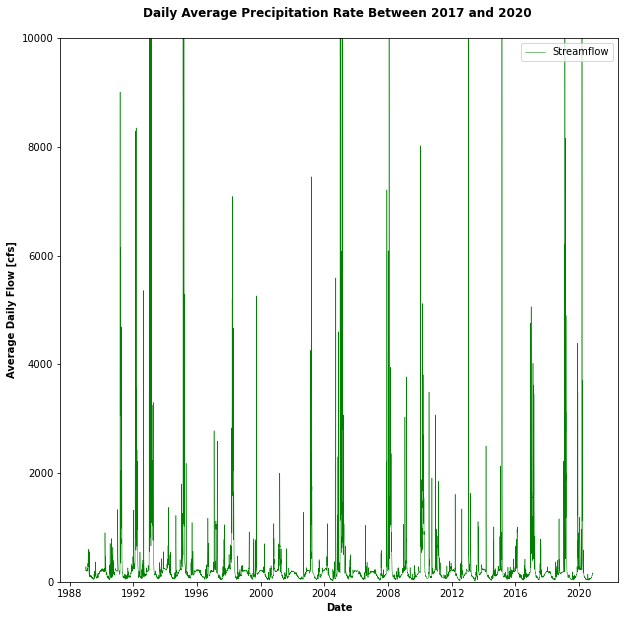

In [7]:
fig, aa = plt.subplots(figsize=(10,10))
aa.plot(stream_data.loc['1989':'2020'].index.values, stream_data['flow']
        ['1989':'2020'], color='green', alpha=1, linewidth=0.5,
        label='Streamflow')
date_form = DateFormatter("%Y")
aa.xaxis.set_major_formatter(date_form)
aa.set_ylabel('Average Daily Flow [cfs]', fontweight='bold')
aa.set_xlabel('Date', fontweight='bold')
aa.set_ylim([0,10000])
aa.set_title('Daily Average Precipitation Rate Between 2017 and 2020 \n',
    fontweight='bold')
aa.legend()

### 3.2. First Approaches

During the first attempts to perform the forecasts, the approach was to select the years where the behavior of the flow were similar to 2020. However, analyzing the average yearly flow was not a good approach since there were years that had very high flows during the first semester, and very low flows during the second one, and in average they resulted similar to 2020.

Hence, I decided to analyze the variation of the flow in a monthly basis along the available years. By using this approach, I was able to figure out monthly which years were more similar to 2020, and then select an accurate training period for the Auto Regressive Models. To support this decision, the box-whiskers plots shown below were used, leading to the conclusion that the most similar years to 2020 during the second semester of the year were 2009, 2017 and 2019. 

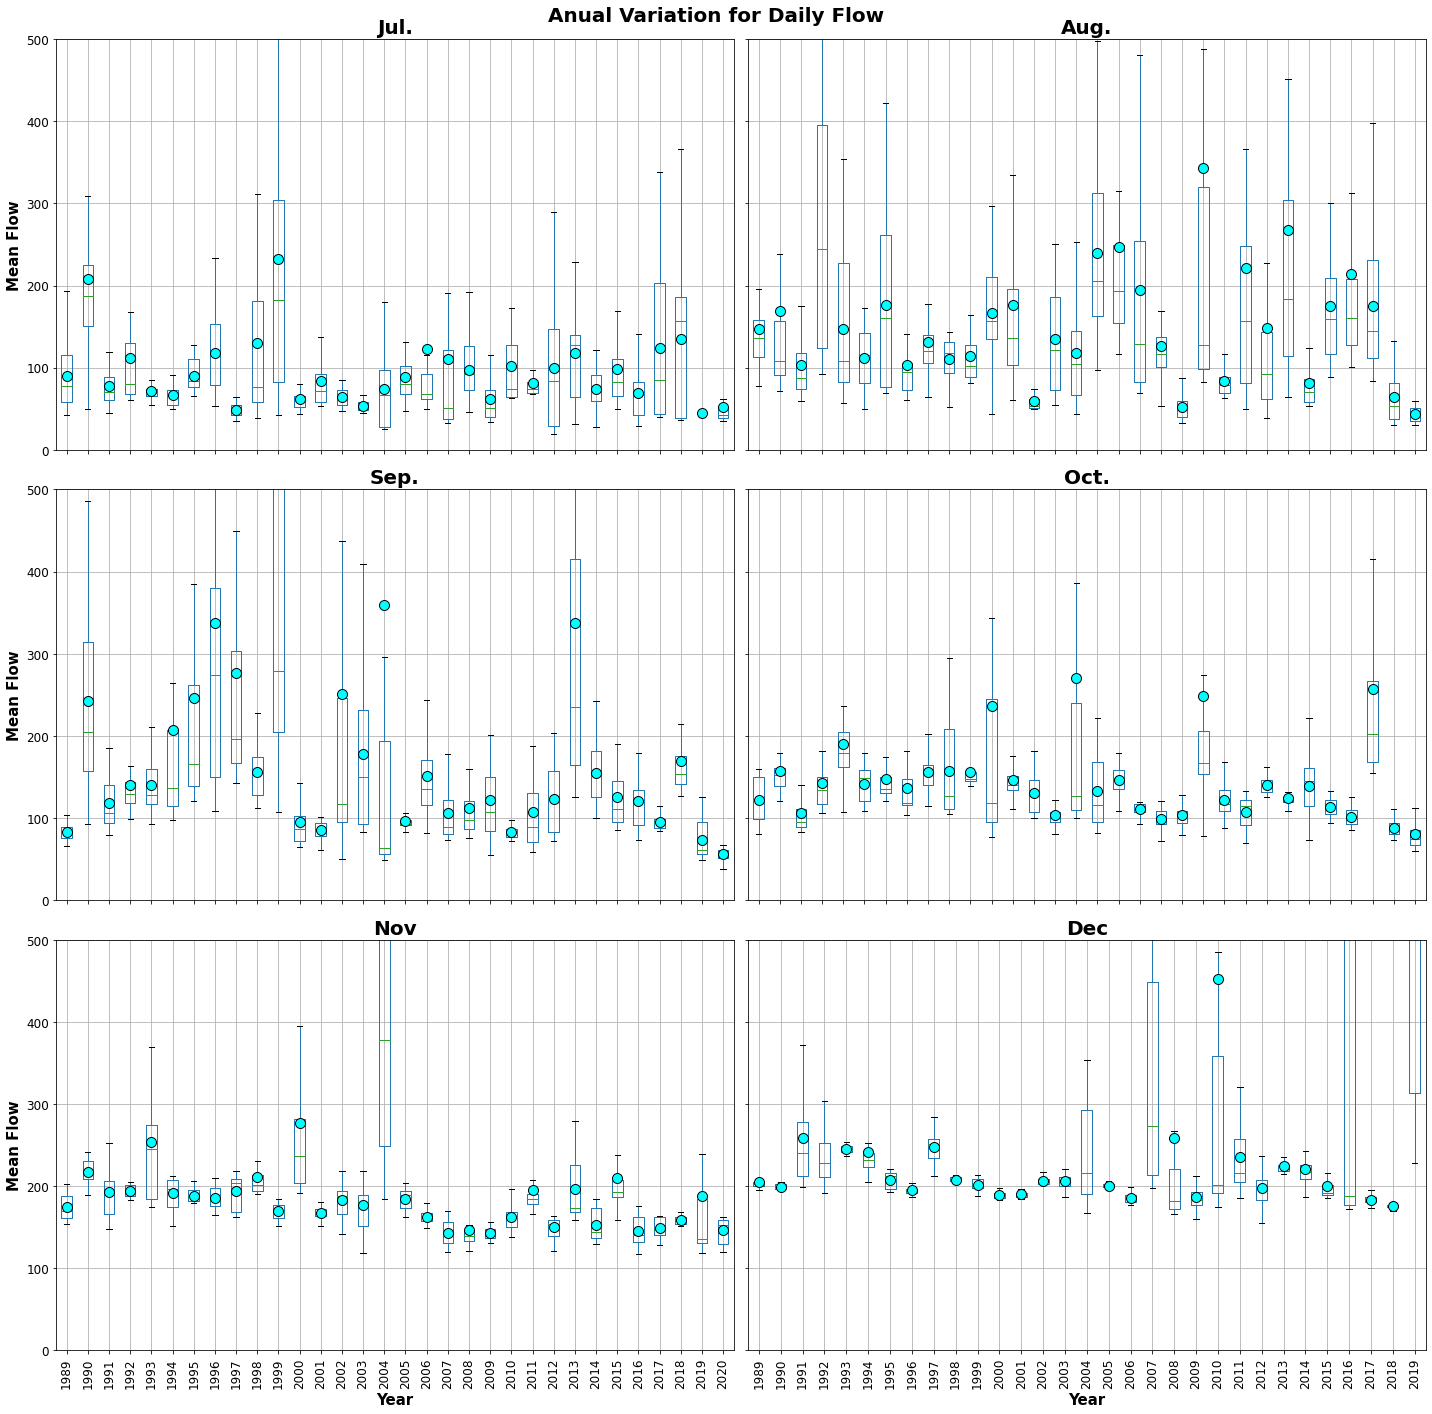

In [39]:
#Data Analysis
months=['Jan.','Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sep.','Oct.','Nov','Dec']


#Plot creation
fig, axes=plt.subplots(nrows=3,ncols=2, sharex=False, figsize=(20,20))
axes=axes.flatten()

for i in range(7,13,1):
        monthlyData=stream_data.loc[stream_data.index.month==i]
        monthlyData.boxplot(column=['flow'],by=[monthlyData.index.year], showfliers=False, \
                            showmeans=True, meanprops={'marker':'o','markerfacecolor':'cyan', \
                                                       'markersize':10,'markeredgecolor':'black'},\
                            meanline=False, ax=axes[i-7])
        axes[i-7].set_title(months[i-1],size=20, fontweight='bold')
        axes[i-7].set_xlabel('Year', size=15, fontweight='bold')
        axes[i-7].set_ylabel('Mean Flow', size=15, fontweight='bold')
        axes[i-7].set_ylim(0,500)
        axes[i-7].tick_params(axis='x',labelsize=12, rotation=90)
        axes[i-7].tick_params(axis='y',labelsize=12)
        

fig.suptitle('Anual Variation for Daily Flow',fontweight='bold', fontsize=20)        
fig.subplots_adjust(hspace=0.5)

for ax in axes:
        ax.label_outer()
        
for axi in axes.flat:
    axi.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.tight_layout()
plt.show()

### 3.3. The Auto Regressive Model - AR

The Auto Regressive (AR) Model estimates future values of a time series based on historical data. Based on this, an AR model was developed to perform the forecasts for Verde River's flow. This function was developed as I identified a need on running several the script to adjust an AR model, varying parameters as the time shifts and the training period in order to identify the best set of parameters to perform the forecast.

To implement the AR Model, a function was developed in Python: *AR_model_estimate*. This function receives as input the dataframe containing the streamflow, a range of dates to use as training period and the number of shifts used in the model. 

As a result, the function returns the value for the intercept of the fitted AR model, as well as the set of coefficients according to the number of time shifts selected by the user. Also, it returns the determination coefficient of the adjusted AR model. 

The _AR_model_estimate_ was designed only to use a single variable, in this case, the streamflow at the Verde River. The code of the function is shown below.

In [41]:
def AR_model_estimate(df, initial_train_date, final_train_date, time_shifts):
    """ Estimate the parameters of an Auto Regressive Model (AR)

    Parameters:
    ----------
    df: Dataframe containing the flow information.
    initial_date: Initial date for the training period in format 'YYYY-MM-DD'.
    final_date: Final date for the training period in format 'YYYY-MM-DD'.
    time_shifts: Number of time shifts to consider in the AR model.

    Returns:
    ---------
    model_intercept: The intercept of the AR Model
    model_coefficients: The coefficients of the AR Model (size=[time_shifts,1])
    r_sq: Determination Coefficient R2 of the AR Model
    """

    # Define the type of model to use
    model_LR = LinearRegression()

    # Start the shift listing with the string 'Flow'
    shift_list = ['flow']

    # Create additional columns to the dataframe to include desired time \
    # shifts
    for i in range(1, time_shifts+1):
        num_shift = 'flow_tm'+str(i)
        df[num_shift] = df['flow'].shift(i)
        shift_list.append(num_shift)

    # Create a dataframe of training data including all columns of df
    train_data = df[initial_train_date:final_train_date][shift_list]

    # Create the dependent array for the AR model
    y_data = train_data['flow']

    # Create the set of independent variables for the AR Model.
    x_data = train_data[shift_list[1:len(shift_list)]]

    # Fit the corresponding AR Model
    model_LR.fit(x_data, y_data)

    # Save the results of the AR Model
    r_sq = np.round(model_LR.score(x_data, y_data), 4)
    model_intercept = np.round(model_LR.intercept_, 2)
    model_coefficients = np.round(model_LR.coef_, 2)

    # Print the results to the user
    print('AR Model with ', time_shifts, ' shifts')
    print('coefficient of determination:', r_sq)
    print('intercept:', model_intercept)
    print('slope:', model_coefficients)

    return model_intercept, model_coefficients, r_sq

### 3.4. Using Additional Datasets in a Multivariate Approach - Why not?

Given the relationship between the streamflow and other hydrologic variables, it is possible to consider other datasets into the forecasting analysis. As a result, the following datasets from the Historical Reanalysis Data at NOAA: Physical Sciences Lab were selected: Air Temperature and Pressure. After a correlation analysis was performed, it was concluded that they have a very low correlation with the streamflow at Verde River, so they are not going to be used in the forecasting process presented in this notebook.

The correlation between Verde River's flow and the datasets from NOAA are shown below, as well as their corresponding plots.

Correlation with Temperature: 0.17795385947243436


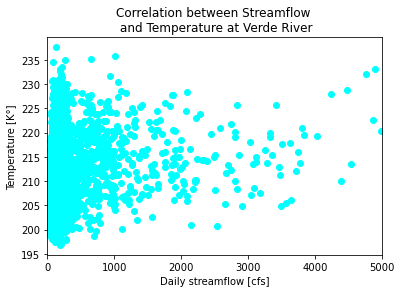

Correlation with Pressure: -0.0251598261616761


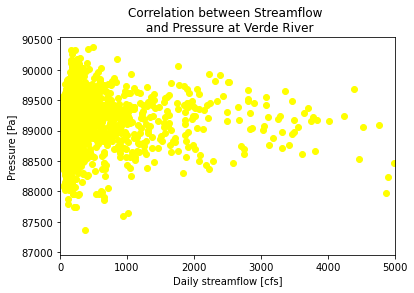

In [8]:
# Information Gathering from CDF

# Net CDF file for historical precipitation rate (in Kg/m^2/s)
data_path_prec = os.path.join('./data', 'PrecipitationRate.nc')

# Net CDF file for historical Temperature (in K degrees)
data_path_temp = os.path.join('./data', 'temp_tropo.nc')

# Net CDF file for historical pressure (in Pascals)
data_path_press = os.path.join('./data', 'Pressure.nc')

# Read the data as an x-array
data_preci = xr.open_dataset(data_path_prec)
data_temp = xr.open_dataset(data_path_temp)
data_press = xr.open_dataset(data_path_press)

# Get the latitude and longitude of each dataset to extract it

# Precipitation
lat_prec = data_preci.prate.lat.values[0]
lon_prec = data_preci.prate.lon.values[0]

# Temperature
lat_temp = data_temp.air.lat.values[0]
lon_temp = data_temp.air.lon.values[0]

# Pressure
lat_press = data_press.pres.lat.values[0]
lon_press = data_press.pres.lon.values[0]

# Extraction of values for each coordinate
loc_prec = data_preci.prate.sel(lat=lat_prec, lon=lon_prec)
loc_temp = data_temp.air.sel(lat=lat_temp, lon=lon_temp)
loc_press = data_press.pres.sel(lat=lat_press, lon=lon_press)

# Conversion of the datasets into dataframes

precip_df = loc_prec.to_dataframe()
temp_df = loc_temp.to_dataframe()
press_df = loc_press.to_dataframe()

# Correlation analysis between Streamflow and Temperature
corr_temp = stream_data['flow']['2009-01-01':'2020-11-01'].\
    corr(temp_df['air']['2009-01-01':'2020-11-01'])
print('Correlation with Temperature:', corr_temp)

# Plot the correlation
fig, ay = plt.subplots()
ay.scatter(stream_data['flow']['2009-01-01':'2020-11-01'], temp_df['air']
           ['2009-01-01':'2020-11-01'], color='cyan', marker='o')
ay.set_xlim([0, 5000])
ay.set_title(
    'Correlation between Streamflow \n and Temperature at Verde River')
ay.set_xlabel('Daily streamflow [cfs]')
ay.set_ylabel('Temperature [K°]')
plt.show()

# Correlation analysis between Streamflow and Pressure
corr_press = stream_data['flow']['2009-01-01':'2020-11-01'].corr(
    press_df['pres']['2009-01-01':'2020-11-01'])
print('Correlation with Pressure:', corr_press)

# Plot the correlation
fig, az = plt.subplots()
az.scatter(stream_data['flow']['2009-01-01':'2020-11-01'],
           press_df['pres']['2009-01-01':'2020-11-01'],
           color='yellow', marker='o')
az.set_xlim([0, 5000])
az.set_title(
    'Correlation between Streamflow \n and Pressure at Verde River')
az.set_xlabel('Daily streamflow [cfs]')
az.set_ylabel('Pressure [Pa]')
plt.show()

## 4. Performing the Forecasts

The forecasts for the streamflow at the Verde River are performed by using an AR Model. In most of the cases, it was selected 3 time shifts because it showed a better performance than 1, 2, 4 or 5 time lags in terms of the determination coefficient R^2. In addition to this fact, the two conclusions described below were drawn from the forecasting activities along the semester:

1. Time scale is important to the accuracy of the forecasts. First, for the _Weekly forecasts_, it is better to use daily-based streamflow data. Once the flow has been predicted in a daily-basis, it can be grouped weekly. On the other hand, for the _Seasonal forecasts_ is better to use weekly-based data into the AR Model. Otherwise, the linear regression will tend to a constant value, which is not appropriate for the forecasts.

2. In an AR model the training period is a fundamental aspect to obtain good results. Given the behavior of the analyzed time series, where there are peaks and valleys along the year, using long training periods is not recommended. Instead, using short times of period for the training of the model has led to better results, measured in terms of the coefficient of determination R^2, which have had values over 0.90. 

Based on the previous conclusions, the function _forecast_flows_ was developed to run the _AR_model_estimate_ function, and perform the forecasts, both weekly and seasonal. As an input, the developed function requires a dataframe with the daily streamflow, the number of desired time shifts, the time period to train the model, the time period to perform the forecast and the type of forecast (weekly or seasonal).

As a result, the function prints the parameters of the resulting AR model, a dataframe with the daily forecasted values and a dataframe with the weekly forecasted values. The code for the function is shown below.

In [42]:
def forecast_flows(flow_daily, time_shifts, start_train_date, end_train_date,
                   start_for_date, end_for_date, seasonal):
    """ Forecast the flows for a given number of periods based on flow timeseries

    Parameters:
    -----------
    flow_daily: Dataframe containing the daily flow information. The index of \
            the df should be the date and this df should only include 'flow'.
    time_shifts: Number of time shifts to consider in the AR Model
    start_train_date: Initial date for the training period in format
                      'YYYY-MM-DD'.
    end_train_date: Final date for the training period in format 'YYYY-MM-DD'.
    start_for_date: Initial date for the forecast in format 'YYYY-MM-DD'.
    end_for_date: Final date for the forecast in format 'YYYY-MM-DD'.
    seasonal: Binary condition telling the scale of time of the forecast.

    Returns:
    -----------
    flow_daily: Dataframe with the forecasts in a daily basis
    flow_weekly: Dataframe with the forecasts in a weekly basis
    model_intercept: Intercept from the AR Model
    model_coefficients: List of coefficients from the AR Model
    """

    # Get the location (index) for the day before the start forecasting \
    # date in the original dataframe (data)

    temp_data = flow_daily
    temp_data = temp_data.reset_index()
    temp_data['datetime'] = flow_daily.index  # .strftime('%Y-%m-%d')

    if seasonal == 'week':
        date_before_start = (pd.to_datetime(start_for_date) +
                             dt.timedelta(days=-1)).date()
        index_lag1 = temp_data.loc[temp_data.datetime == str(
            date_before_start)].index[0]
    elif seasonal == 'seasonal':
        flow_daily = flow_daily.resample("W-SUN", closed='left', label='left')\
            .mean()
        index_lag1 = flow_daily.shape[0]-1
        print(index_lag1)
    else:
        print('Please choose a valid time horizon for forecast')

    # Create a list of dates (daily) for the forecast period
    if seasonal == 'week':
        forecast_period = pd.date_range(start=start_for_date,
                                        end=end_for_date, freq='D')
    elif seasonal == 'seasonal':
        forecast_period = pd.date_range(start=start_for_date,
                                        end=end_for_date, freq='W')

    # Estimate the parameters for the best-fit AR Model
    model_intercept, model_coefficients, r_sq = AR_model_estimate(
        flow_daily, start_train_date, end_train_date, time_shifts)

    # Calculate the Forecasts for the indicated time range based on the \
    # selected timeshifts.
    # "lag_i" is used to extract the flow value based on the order of the \
    # AR Model using the index located for the day before the start of \
    # forecast.
    lag_i = index_lag1+1

    # Initialize the variable for the forecasts
    forecast_val = 0

    # Using two loops, the forecasts are calculated between \
    # the desired range of dates, and then appended to the dataframe

    for i in range(0, forecast_period.shape[0]):
        for k in range(0, time_shifts):
            forecast_val += model_coefficients[k] * \
                flow_daily.iloc[lag_i-(k+1)]['flow']
        forecast_val += model_intercept
        lag_i += 1
        flow_daily.loc[forecast_period[i], ['flow']] = forecast_val
        forecast_val = 0

    # Resampling the forecast in a weekly basis, starting on Sundays and \
    # setting the labels and closed interval at the left
    if seasonal == 'week':
        flow_weekly = flow_daily.loc[start_for_date:end_for_date][['flow']].\
            resample("W-SUN", closed='left', label='left').mean()
    elif seasonal == 'seasonal':
        flow_weekly = flow_daily.loc[start_for_date:end_for_date][['flow']]

    # Print the forecasts for the competition
    for i in range(flow_weekly.shape[0]):
        print('\n Week #', str(i+1), '-', flow_weekly.iloc[i].name, '(cfs): ',
              np.round(flow_weekly.iloc[i]['flow'], 2))

    return flow_daily, flow_weekly, model_intercept, model_coefficients

### 4.1. Results of the Forecasts

The results after running the AR models described before are presented. First, the weekly forecasts and then the seasonal results.

#### 4.1.1. Weekly Results

For the weekly results, an AR3 model was used. The training period and the coefficient of determination are shown in the table below.

|AR Model|Training Start Date|Training End Date|R^2|
| ------ | ----------------- | --------------- | --- |
|Week (1 & 2)|2017-10-01|2017-12-15|0.9921|

As a result, the obtained values for the forecast are:

_**1 Week (2020-11-22 to 2020-11-28):**_ 158.23 cfs

_**2 Week (2020-11-29 to 2020-12-05):**_ 167.88 cfs

The code is shown below.


In [46]:
# Common dataframe for both forecasts including only the flow column
daily_flow = stream_data[['flow']]
daily_flow = daily_flow.set_index(pd.to_datetime(stream_data.index))

# Two-week forecast

# Training period for the AR Model
start_train_date = '2017-10-01'
end_train_date = '2017-12-15'

# Forecasting period
start_for_date = '2020-11-22'
end_for_date = '2020-12-05'

# Used parameters for the model
# Number of shifts
time_shifts = 3

# Function Call
flow_daily_2w, flow_weekly_2w, model_intercept, model_coefficients = \
    forecast_flows(daily_flow, time_shifts, start_train_date,
                       end_train_date, start_for_date, end_for_date, 'week')

AR Model with  3  shifts
coefficient of determination: 0.9921
intercept: 1.69
slope: [ 1.06 -0.35  0.29]

 Week # 1 - 2020-11-22 00:00:00 (cfs):  158.23

 Week # 2 - 2020-11-29 00:00:00 (cfs):  167.88


#### 4.1.2. Seasonal Results

For the Seasonal results, two different AR3 models were used. The main reason for this decision was the capability of the training period to reach good results along all the semester based on a limited data (Only until Aug. 22/2020). The training periods and the coefficients of determination are shown in the table below.

|AR Model|Training Start Date|Training End Date|R^2|
| ------ | ----------------- | --------------- | --- |
|Seasonal - 1st 10 weeks|2017-08-25|2017-11-10|0.7673|
|Seasonal - Remaining weeks|2017-10-01|2017-12-15|0.9886|

As a result, the forecasted values are shown below, measured in [cfs].


|Week 1|Week 2|Week 3|Week 4|Week 5|Week 6|Week 7|Week 8|Week 9|Week 10|Week 11|Week 12|Week 13|Week 14|Week 15|
|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
|42.97|53.44|64.86|76.24|87.09|97.21|106.52|115.03|122.78|129.83|138.71|146.75|155.39|163.13|170.82|177.65|


In [47]:
# Seasonal Forecast for weeks between Aug. 22 to Oct. 31

# Training period for the AR Model for first 6 weeks
start_train_date = '2017-08-25'
end_train_date = '2017-11-10'

# Forecasting period for first 6 weeks
start_for_date = '2020-08-22'
end_for_date = '2020-10-31'

# Number of shifts
time_shifts = 3

# Common dataframe for both forecasts including only the flow column
daily_flow_16w_1 = stream_data.loc['1989-01-01':start_for_date][['flow']]

# Function Call
flow_daily_seas1, flow_weekly_seas1, model_intercept16_1, \
    model_coefficients16_1 = forecast_flows(daily_flow_16w_1, time_shifts,
                                                start_train_date, end_train_date, start_for_date, end_for_date,
                                                'seasonal')


1650
AR Model with  3  shifts
coefficient of determination: 0.7673
intercept: 9.88
slope: [ 1.31 -0.3  -0.06]

 Week # 1 - 2020-08-23 00:00:00 (cfs):  42.97

 Week # 2 - 2020-08-30 00:00:00 (cfs):  53.44

 Week # 3 - 2020-09-06 00:00:00 (cfs):  64.86

 Week # 4 - 2020-09-13 00:00:00 (cfs):  76.24

 Week # 5 - 2020-09-20 00:00:00 (cfs):  87.09

 Week # 6 - 2020-09-27 00:00:00 (cfs):  97.21

 Week # 7 - 2020-10-04 00:00:00 (cfs):  106.52

 Week # 8 - 2020-10-11 00:00:00 (cfs):  115.03

 Week # 9 - 2020-10-18 00:00:00 (cfs):  122.78

 Week # 10 - 2020-10-25 00:00:00 (cfs):  129.83


In [49]:
# Seasonal Forecast for weeks between Nov. 01 to Dec. 12
# NOTE: I did not use the outputs printed by the model to make the forecasts.\
# Rather, I used the model determined by the function.

# Training period for the AR Model for first 6 weeks
start_train_date = '2017-10-01'
end_train_date = '2017-12-15'

# Forecasting period for first 6 weeks
start_for_date = '2020-11-01'
end_for_date = '2020-12-12'

# Number of shifts
time_shifts = 3

# Common dataframe for both forecasts including only the flow column
daily_flow_16w_2 = flow_daily_seas1.loc['1989-01-01':start_for_date][['flow']]

# Function Call
flow_daily_seas2, flow_weekly_seas2, model_intercept16_2, model_coefficients16_2 = \
    forecast_flows(daily_flow_16w_2, time_shifts, start_train_date,
                       end_train_date, start_for_date, end_for_date, 'seasonal')

1660
AR Model with  3  shifts
coefficient of determination: 0.9886
intercept: 11.26
slope: [ 0.94  0.55 -0.54]

 Week # 1 - 2020-11-01 00:00:00 (cfs):  138.71

 Week # 2 - 2020-11-08 00:00:00 (cfs):  146.75

 Week # 3 - 2020-11-15 00:00:00 (cfs):  155.39

 Week # 4 - 2020-11-22 00:00:00 (cfs):  163.13

 Week # 5 - 2020-11-29 00:00:00 (cfs):  170.82

 Week # 6 - 2020-12-06 00:00:00 (cfs):  177.65


### 4.2. Performance of the Forecasts

#### 4.2.1. Weekly Forecasts

In the plot below, a comparison between the forecasted and the observed values for the Verde River Streamflow is presented in a weekly basis. As it can be seen, at the beginning of the semester the error was very high due to a non-technical way of performing the forecasts. However, after the AR models started to be implemented, the accuracy of the forecasts increased significantly.

In this plot, the 1 week forecasts were used, obtained from the repository. 

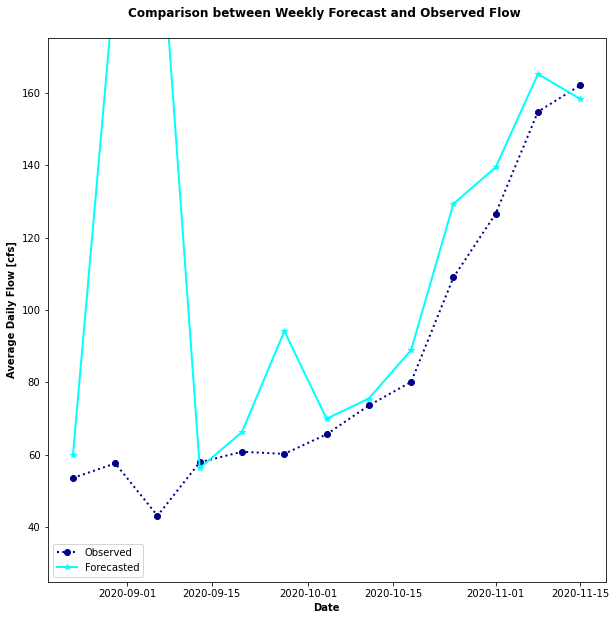

In [66]:
# Plot the Weekly Forecasts against the observed values
week_obs=stream_data.loc['2020-08-23':'2020-11-15'][['flow']].\
            resample("W-SUN", closed='left', label='left').mean()
weekly_for = [60, 192.61, 218.38, 56.39, 66.34, 94.16, 70, 75.57, 88.98, 129.29, 139.39, 165.12, 158.23]

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(week_obs['flow'], color='darkblue', linewidth=2, ls=':',
        marker='o', label='Observed')
ax.plot(week_obs.index, weekly_for, color='cyan', linewidth=2,
        marker='*', label='Forecasted')
ax.set_ylabel('Average Daily Flow [cfs]', fontweight='bold')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylim([25,175])
ax.set_title('Comparison between Weekly Forecast and Observed Flow \n',
    fontweight='bold')
ax.legend()

#### 4.2.2. Seasonal Forecasts

In the plot below, a comparison between the forecasted and the observed values for the Verde River Streamflow is presented. As it can be seen, between Weeks 3 and 11 the trend was to overestimate the flow at the river. On the other side, for the last two analyzed weeks, the trend of my forecasts was to underestimate the observed flow. In addition, it can be seen that when the training period was changed (Week 11), the error was reduced in comparison with the rest of the semester.  

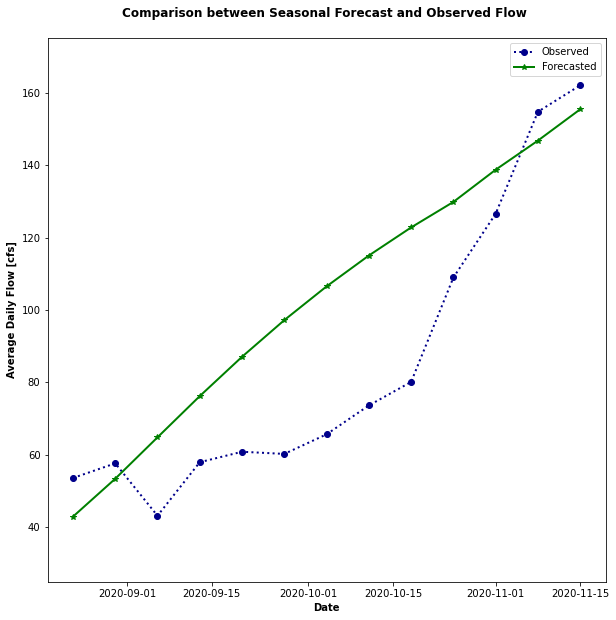

In [62]:
# Plot the Seasonal Forecasts against the observed values
week_obs=stream_data.loc['2020-08-23':'2020-11-15'][['flow']].\
            resample("W-SUN", closed='left', label='left').mean()
seasonal_for = flow_weekly_seas1.append(flow_weekly_seas2)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(week_obs['flow'], color='darkblue', linewidth=2, ls=':',
        marker='o', label='Observed')
ax.plot(seasonal_for.loc['2020-08-23':'2020-11-15']['flow'], color='green', linewidth=2,
        marker='*', label='Forecasted')
ax.set_ylabel('Average Daily Flow [cfs]', fontweight='bold')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylim([25,175])
ax.set_title('Comparison between Seasonal Forecast and Observed Flow \n',
    fontweight='bold')
ax.legend()
